In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime as dt

import sqlite3 as sql

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix, f1_score, classification_report, accuracy_score, roc_auc_score

In [2]:
pd.set_option('display.max_columns',100)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
print(os.listdir("../"))

%matplotlib inline


# Any results you write to the current directory are saved as output.

['~$S Background Application – Whitt.docx', '.DS_Store', 'Risks&Reduction_Capstone.docx', '.localized', 'bdsproject', 'SampleMQTTAndroidApp', 'BusinessSH', 'APAD', 'Whitt_Hyde.jpeg', 'IoT', 'BusinessProblem_Capstone.docx', 'Kaggle_report_wjh695', 'ColbyChaosThanos.jpeg', 'FPA_FOD_20170508.sqlite', 'KingTetris.jpg', '.ipynb_checkpoints', 'bds-hw', 'Jobs', 'ugca-fall', '~$Jobs2019.xlsx', 'Downloads', 'SummerClasses', 'BigData']


In [3]:
conn = sql.connect("FPA_FOD_20170508.sqlite")


In [4]:
# pip install plotly-geo

In [5]:
cur = conn.cursor()
cur.execute("SELECT * FROM fires")

rows = cur.fetchall()


In [6]:
wfdf = pd.read_sql("Select * from fires",con= conn)

In [7]:
wfdf.shape


(1880465, 39)

In [8]:
wfdf.columns


Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_INCIDENT_NUMBER', 'ICS_209_NAME', 'MTBS_ID', 'MTBS_FIRE_NAME',
       'COMPLEX_NAME', 'FIRE_YEAR', 'DISCOVERY_DATE', 'DISCOVERY_DOY',
       'DISCOVERY_TIME', 'STAT_CAUSE_CODE', 'STAT_CAUSE_DESCR', 'CONT_DATE',
       'CONT_DOY', 'CONT_TIME', 'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE',
       'LONGITUDE', 'OWNER_CODE', 'OWNER_DESCR', 'STATE', 'COUNTY',
       'FIPS_CODE', 'FIPS_NAME', 'Shape'],
      dtype='object')

In [9]:
epoch = pd.to_datetime(0, unit='s').to_julian_date()
wfdf['CONT_DATE'] = pd.to_datetime(wfdf['CONT_DATE'] - epoch, unit='D')
wfdf['DISCOVERY_DATE'] = pd.to_datetime(wfdf['DISCOVERY_DATE'] - epoch, unit = 'D')
wfdf['FIRE_DURATION'] = wfdf['CONT_DATE'] - wfdf['DISCOVERY_DATE']
wfdf['FIRE_DURATION'] = wfdf['FIRE_DURATION'].dt.days
wfdf['FIRE_DURATION'].fillna(wfdf['FIRE_DURATION'].mean(),inplace = True)
wfdf['FIRE_DURATION'] = wfdf['FIRE_DURATION'].apply(lambda x : int(x))

In [10]:
wfdf.head()


,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape,FIRE_DURATION
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2005-02-02,33,1300,9.0,Miscellaneous,2005-02-02,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...,0
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2004-05-12,133,0845,1.0,Lightning,2004-05-12,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...,0
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2004-05-31,152,1921,5.0,Debris Burning,2004-05-31,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...,0
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...,5
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2004-06-28,180,1600,1.0,Lightning,2004-07-03,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...,5


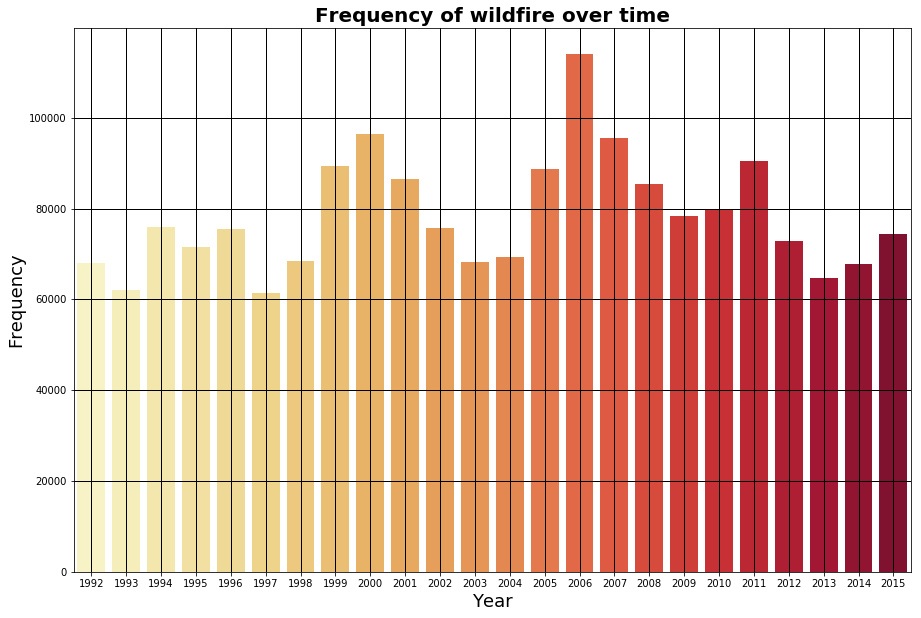

In [11]:
plt.figure(figsize=(15, 10))
ax = sns.countplot(x="FIRE_YEAR", data = wfdf, palette="YlOrRd")
ax.set_title("Frequency of wildfire over time", fontdict = {'fontsize':20, 'fontweight':'bold'})
ax.set_xlabel("Year", fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_ylabel("Frequency", fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.grid(which = 'major',color = 'black', linewidth = 1)

[Text(0, 0, '0.26-9.9'),
 Text(0, 0, '0-2.5'),
 Text(0, 0, '10.0-99.9'),
 Text(0, 0, '100-299'),
 Text(0, 0, '300-999'),
 Text(0, 0, '1000-4999'),
 Text(0, 0, '5000+')]

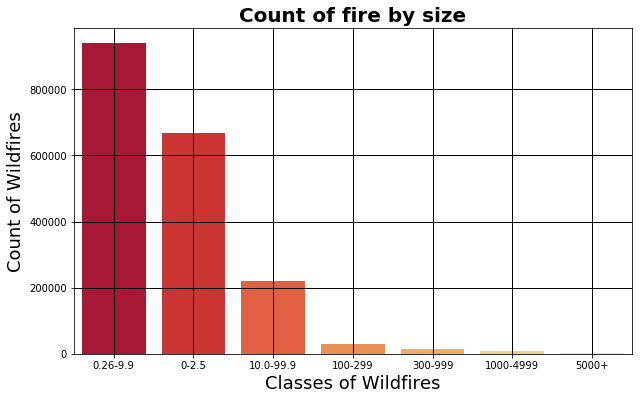

In [12]:
labels = {'B':'0.26-9.9',
          'A':'0-2.5', 
          'C':'10.0-99.9', 
          'D':'100-299', 
          'E':'300-999', 
          'F':'1000-4999', 
          'G': '5000+'}
plt.figure(figsize=(10,6))
ax= sns.countplot(x = 'FIRE_SIZE_CLASS', data = wfdf, palette = 'YlOrRd_r', order = wfdf['FIRE_SIZE_CLASS'].value_counts().index)
ax.set_xlabel('Classes of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_ylabel('Count of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Count of fire by size', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid(linewidth = 1, color = 'black')
ax.set_xticklabels(labels.values())

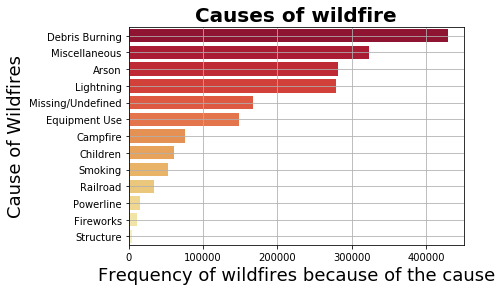

In [13]:
ax = sns.countplot(y = 'STAT_CAUSE_DESCR', data = wfdf, palette = 'YlOrRd_r', order=wfdf['STAT_CAUSE_DESCR'].value_counts().index)
ax.set_ylabel('Cause of Wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_xlabel('Frequency of wildfires because of the cause', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Causes of wildfire', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid()

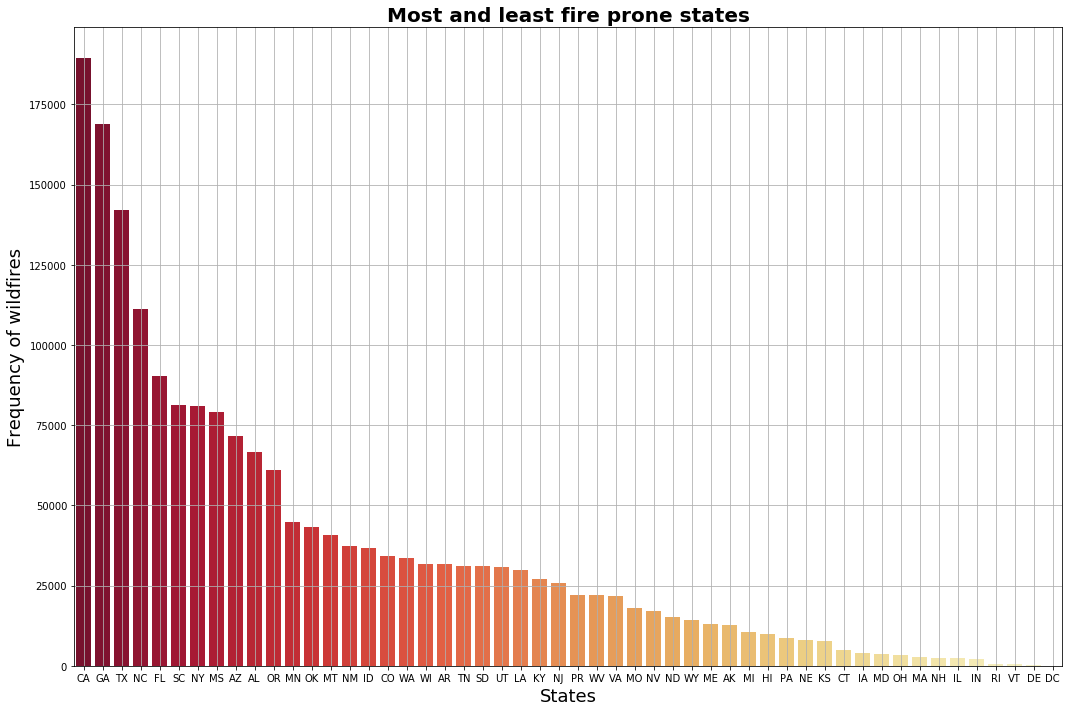

In [14]:
plt.figure(figsize = (15,10))
ax = sns.countplot(x = 'STATE' , data = wfdf, palette = 'YlOrRd_r', order = wfdf['STATE'].value_counts().index)
ax.set_ylabel('Frequency of wildfires', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_xlabel('States', fontdict = {'fontsize':18, 'fontweight': 'medium'})
ax.set_title('Fire by States', fontdict = {'fontsize':20, 'fontweight': 'bold'})
ax.grid()
plt.tight_layout()

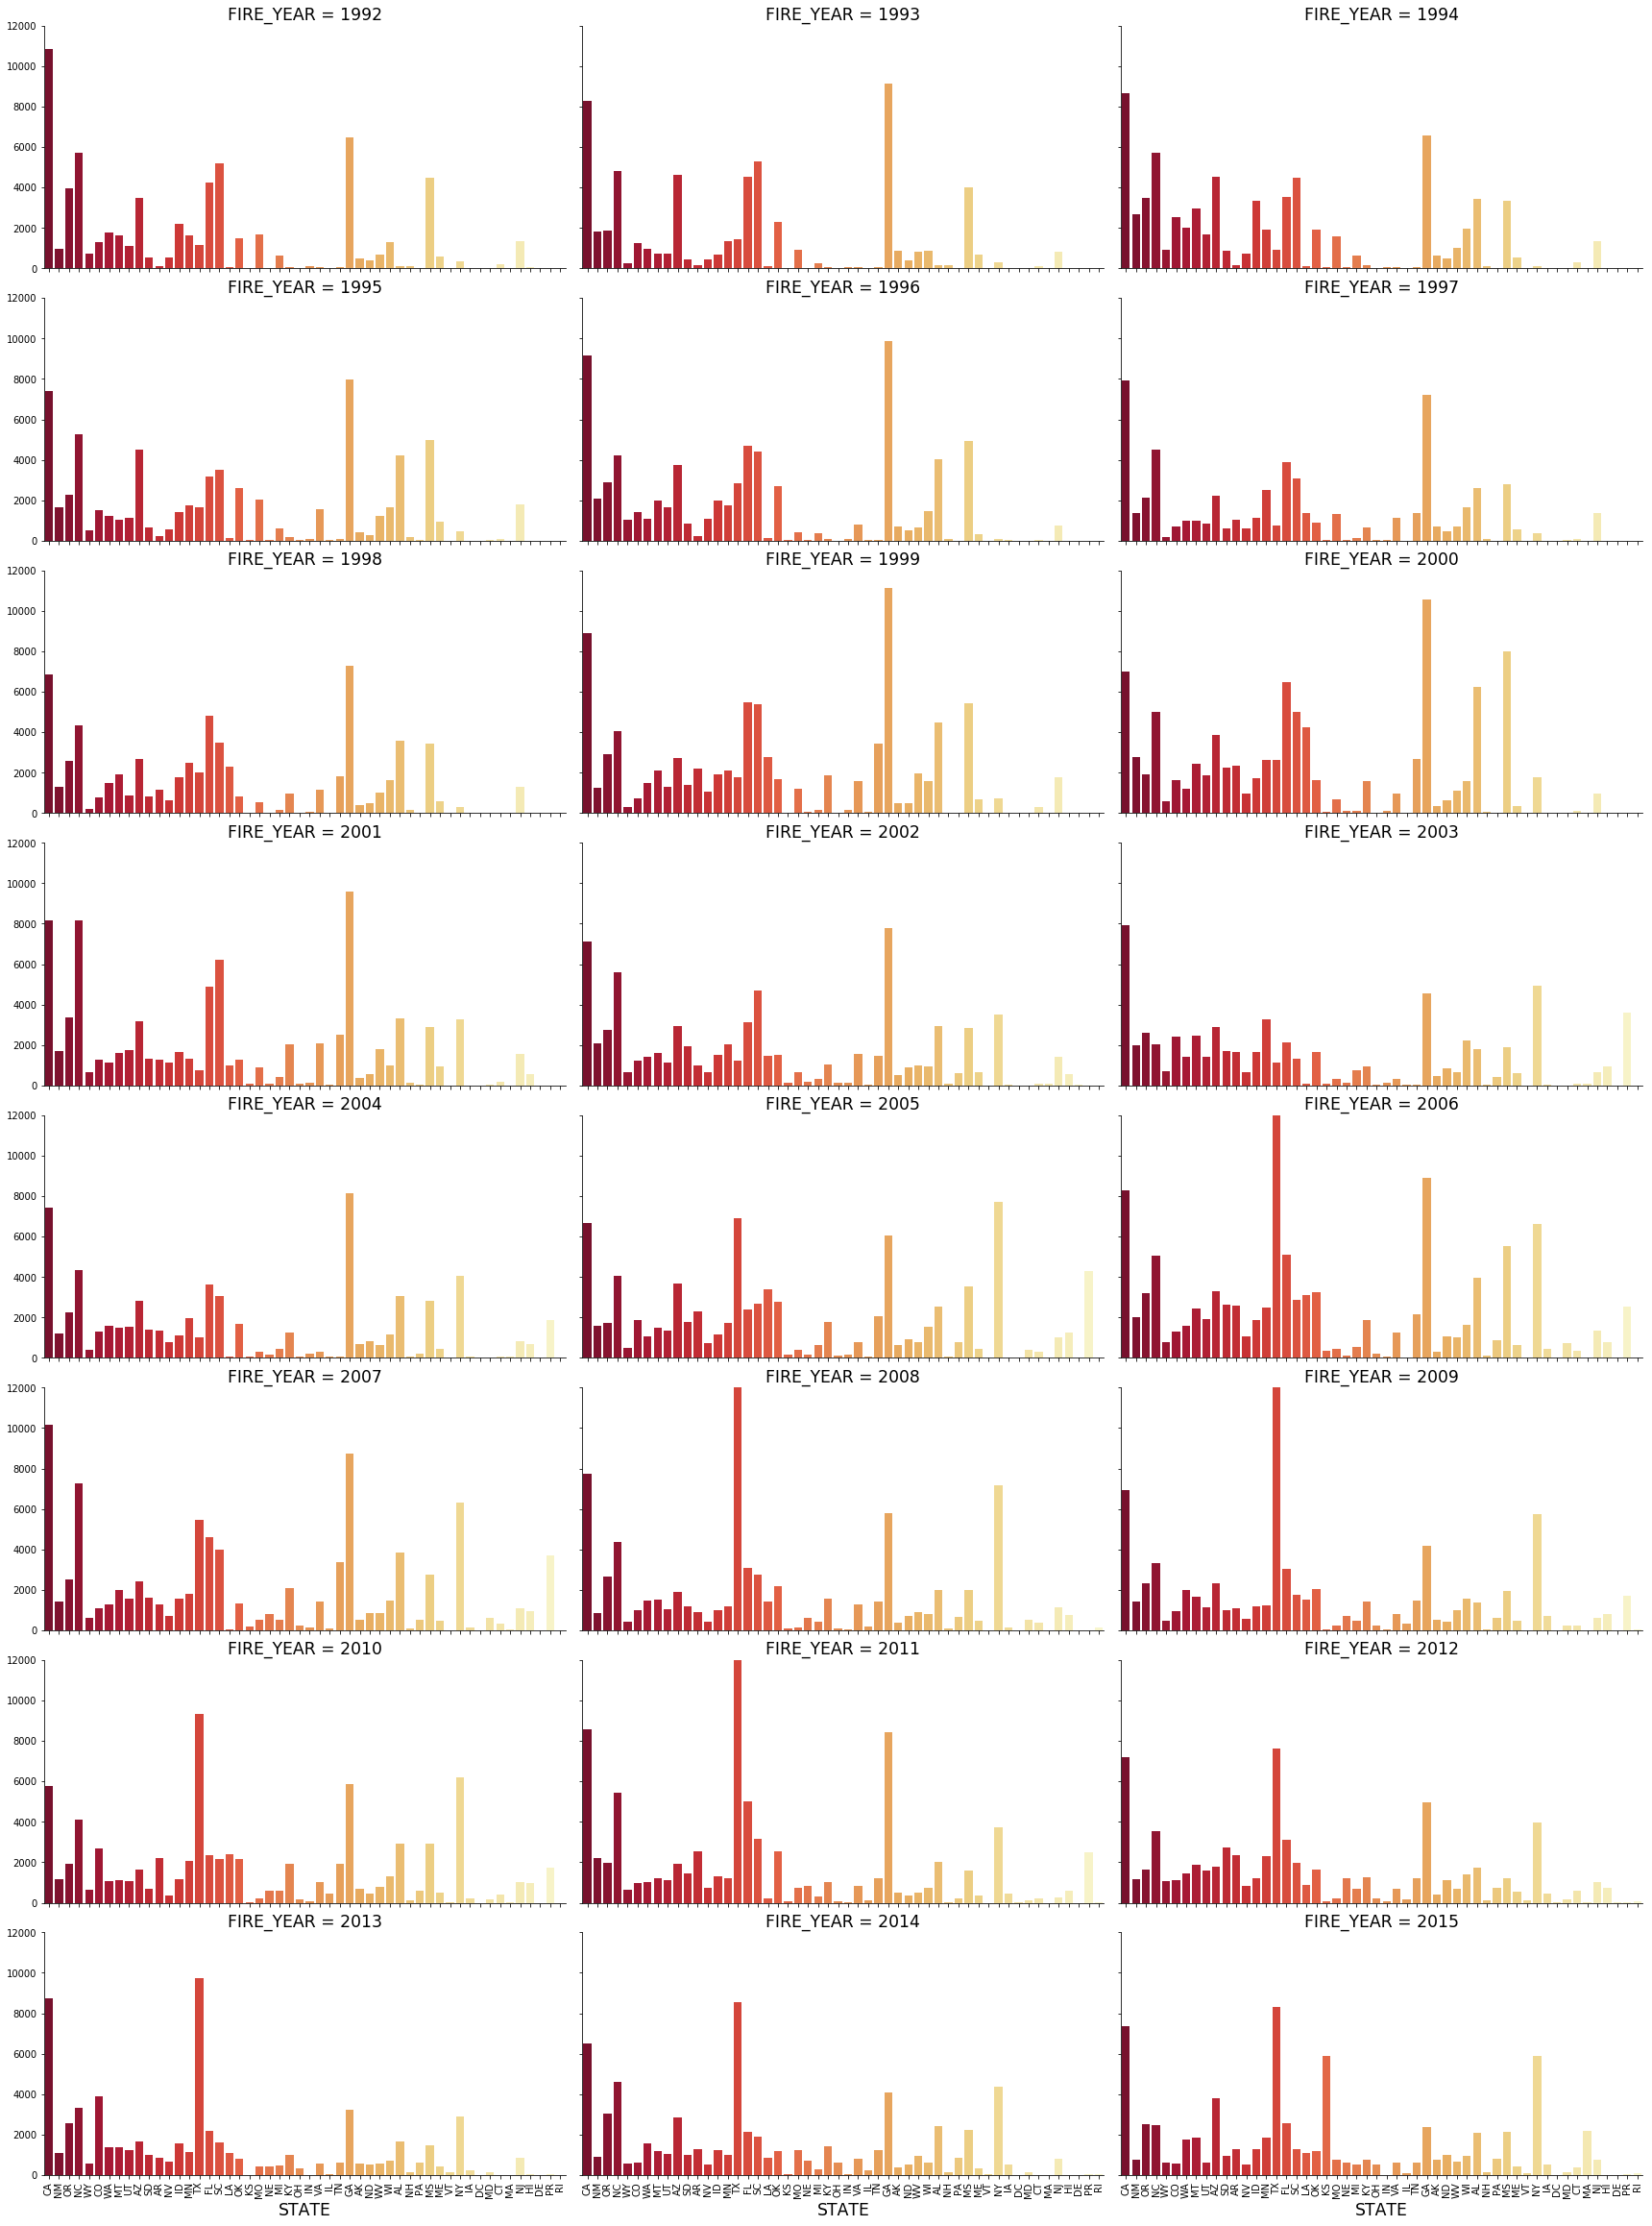

In [15]:
grid = sns.FacetGrid(data= wfdf , col = 'FIRE_YEAR', height = 4, aspect = 2, col_wrap=3)
grid.map(sns.countplot, 'STATE', order = wfdf['STATE'].unique(), palette = 'YlOrRd_r')
grid.set_xticklabels(rotation = 90, fontdict = {'fontsize':10})
grid.set(ylim = (0,12000))
for ax in grid.axes.flat:
    ax.set_title(ax.get_title(), fontsize='xx-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='xx-large')
    ax.set_xlabel(ax.get_xlabel(),fontsize = 'xx-large')
# plt.tight_layout()

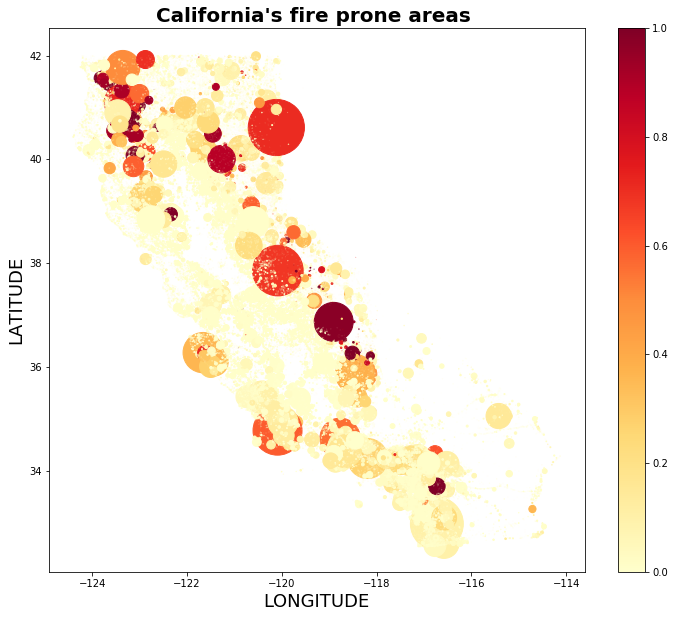

In [38]:
ca_data = wfdf[wfdf['STATE'] == 'CA']
plt.figure(figsize=(12,10))
plt.scatter(x = ca_data['LONGITUDE'],y = ca_data['LATITUDE'],sizes = ca_data['FIRE_SIZE']/100,c = ca_data['FIRE_DURATION']/100, cmap='YlOrRd', vmin=0.0, vmax=1.0)
plt.colorbar()
plt.xlabel('LONGITUDE', fontdict={'fontsize' : 18, 'fontweight' : 'medium'})
plt.ylabel('LATITUDE', fontdict={'fontsize' : 18, 'fontweight' : 'medium'})
plt.title("California's fire prone areas ",fontdict={'fontsize' : 20, 'fontweight' : 'bold'})
plt.show()

The circular spots represent the firesize that is the spread of fire in acres and the color internsity that is as we move from yellow to red scale the duration to bring the fire under control increases, which can be also looked as the number days required to bring the fire under control is directly proportional to how intense the fire was


In [21]:
len(fips)

1880465

In [27]:
wfdf['STATE'].value_counts()

CA    189550
GA    168867
TX    142021
NC    111277
FL     90261
SC     81315
NY     80870
MS     79230
AZ     71586
AL     66570
OR     61088
MN     44769
OK     43239
MT     40767
NM     37478
ID     36698
CO     34157
WA     33513
WI     31861
AR     31663
TN     31154
SD     30963
UT     30725
LA     30013
KY     27089
NJ     25949
PR     22081
WV     21967
VA     21833
MO     17953
NV     16956
ND     15201
WY     14166
ME     13150
AK     12843
MI     10502
HI      9895
PA      8712
NE      7973
KS      7673
CT      4976
IA      4134
MD      3622
OH      3479
MA      2626
NH      2452
IL      2327
IN      2098
RI       480
VT       456
DE       171
DC        66
Name: STATE, dtype: int64

In [28]:
fips = wfdf['FIPS_CODE'].tolist()
colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
              "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
              "#08519c","#0b4083","#08306b"]

fig = ff.create_choropleth(fips = fips , values = wfdf['STATE'].value_counts(), colorscale = colorscale, show_state_data= False, 
                           show_hover= True, centroid_marker={'opacity':0}, asp = 2.9, title='USA Fires %')
fig.show()

PlotlyError: You have 52 LEVELS. Your number of colors in 'colorscale' must be at least the number of LEVELS: ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA']. If you are using 'binning_endpoints' then 'colorscale' must have at least len(binning_endpoints) + 2 colors

In [33]:
layout = dict(title = 'Fire Prone States',
              geo = dict(scope='usa',
                         showlakes = True,
                         lakecolor = 'rgb(85,173,240)')
             )


In [ ]:
choromap = go.Figure(data=data, layout=layout)
# iplot(choromap,validate=False)
py.plot(choromap)

In [ ]:
wfdf.head()

In [ ]:
features = wfdf[['STATE', 'FIPS_NAME', 'FIRE_DURATION','DISCOVERY_DATE', 'FIRE_SIZE_CLASS']]
label = wfdf['STAT_CAUSE_DESCR']


Since the chosen feature 'STATE' is categorical variable I need to convert it to numerical variable. So I'll be performing one hot encoding to convert 'STATE' to numerical variable

In [ ]:
label_encoder = LabelEncoder()


In [ ]:
encoded_state = label_encoder.fit_transform(features['STATE'])
